In [2]:
from pandas import json_normalize
import pandas as pd
import json

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm


def flattened_idx_to_layer_head(flattened_idx, num_heads):
    return flattened_idx // num_heads, flattened_idx % num_heads

def layer_head_to_flattened_idx(layer, head, num_heads):
    return layer * num_heads + head

def get_top_heads(train_idxs, val_idxs, separated_activations, separated_labels, num_layers, num_heads, seed, num_to_intervene, use_random_dir=False, specific_heads = None):

    probes, all_head_accs_np, train_accs = train_probes(seed, train_idxs, val_idxs, separated_activations, separated_labels, num_layers=num_layers, num_heads=num_heads)
    all_head_accs_np = all_head_accs_np.reshape(num_layers, num_heads)

    if specific_heads is not None:
        top_heads = [layer_head_to_flattened_idx(head[0], head[1], num_heads) for head in specific_heads]
        
    else:
        
        top_heads = []
        top_accs = np.argsort(all_head_accs_np.reshape(num_heads*num_layers))[::-1][:num_to_intervene]
        print(top_accs)
        #print(top_accs[0:5])
        top_heads = [flattened_idx_to_layer_head(idx, num_heads) for idx in top_accs]
    if use_random_dir: 
        # overwrite top heads with random heads, no replacement
        random_idxs = np.random.choice(num_heads*num_layers, num_heads*num_layers, replace=False)
        top_heads = [flattened_idx_to_layer_head(idx, num_heads) for idx in random_idxs[:num_to_intervene]]

    return top_heads, probes

def get_interventions_dict(top_heads, probes, tuning_activations, num_heads, use_center_of_mass, use_random_dir, com_directions): 

    interventions = {}
    for layer, head in top_heads: 
        interventions[f"model.layers.{layer}.self_attn.head_out"] = []
    for layer, head in top_heads:
        if use_center_of_mass: 
            direction = com_directions[layer_head_to_flattened_idx(layer, head, num_heads)]
        elif use_random_dir: 
            direction = np.random.normal(size=(128,))
        else: 
            direction = probes[layer_head_to_flattened_idx(layer, head, num_heads)].coef_
        direction = direction / np.linalg.norm(direction)
        activations = tuning_activations[:,layer,head,:] # batch x 128
        proj_vals = activations @ direction.T
        proj_val_std = np.std(proj_vals)
        interventions[f"model.layers.{layer}.self_attn.head_out"].append((head, direction.squeeze(), proj_val_std))
        
    for layer, head in top_heads: 
        interventions[f"model.layers.{layer}.self_attn.head_out"] = sorted(interventions[f"model.layers.{layer}.self_attn.head_out"], key = lambda x: x[0])

    return interventions

from sklearn.linear_model import LogisticRegression

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.svm import SVC
def train_probes(seed, train_set_idxs, val_set_idxs, separated_head_wise_activations, separated_labels, num_layers, num_heads,c=100):
    
    all_head_accs = []
    probes = []
    train_accs = []
    all_X_train = np.concatenate([separated_head_wise_activations[i] for i in train_set_idxs], axis = 0)
    print(all_X_train.shape)
    all_X_val = np.concatenate([separated_head_wise_activations[i] for i in val_set_idxs], axis = 0)
    y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
    print(y_train.shape)
    y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)

    for layer in tqdm(range(num_layers)): 
        for head in range(num_heads): 
            
            X_train = all_X_train[:,layer,head,:]
            
            dim_reduction = PCA(n_components = 1).fit(X_train)
            X_train_transform = dim_reduction.transform(X_train)
            X_val = all_X_val[:,layer,head,:]
            X_val_transform = dim_reduction.transform(X_val)
            #X_train = X_train_transform
            #X_val = X_val_transform
            
            clf = LogisticRegression(random_state=seed, max_iter=10000, tol= 10e-5).fit(X_train, y_train)

            
            #clf = LogisticRegression(random_state=seed, max_iter=10000, penalty='l1', solver='liblinear', C=100000).fit(X_train, y_train)
            #clf = LogisticRegression(random_state=seed, max_iter=10000,solver='liblinear').fit(X_train, y_train) #, penalty='l1', , C=100000
            
            #clf = LogisticRegression(random_state=seed, C=10, penalty='elasticnet', l1_ratio= 0.5, max_iter=10000, solver='saga').fit(X_train, y_train) #, penalty='l1', , C=100000
            #clf = LogisticRegression(random_state=seed, C=100, penalty='elasticnet', l1_ratio= 0.5, max_iter=10000, solver='saga').fit(X_train, y_train) #, penalty='l1', , C=100000
            #clf = LogisticRegression(random_state=seed, C=c, penalty='elasticnet', l1_ratio= 0.5, max_iter=10000, solver='saga', tol= 10e-5).fit(X_train, y_train) #, penalty='l1', , C=100000
            
            
            #clf = SVC().fit(X_train, y_train)
            #clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
            #if clf.converged_:
             #   print("The model converged.")
            #else:
             #   print("The model did not converge. You might need to increase max_iter or change the solver.")

            y_pred = clf.predict(X_train)
            train_accs.append(accuracy_score(y_train, y_pred))
            y_val_pred = clf.predict(X_val)
            all_head_accs.append(accuracy_score(y_val, y_val_pred))

            probes.append(clf)

    all_head_accs_np = np.array(all_head_accs)
    train_accs_np = np.array(train_accs)
    return probes, all_head_accs_np, train_accs_np


In [3]:
df = pd.read_json("requirements_data/dataframe_open_chat_cot_moon_06022024_attentions_gt.json")

df.reset_index(drop=True, inplace=True)
correct = [0 if value == "yes" else 1 for value in df.predict.values]
df.correct = correct

In [4]:
import numpy as np 

index_dic = {}
separated_activations = []
separated_labels = []
reqs_order = []
for req_id in df['req_id'].unique():

    req_df = df[df['req_id'] == req_id].index

    #req_ids.append(req_df)
    index_dic[req_id] = list(req_df)
    
    temp_activations = df[df['req_id'] == req_id].attentions
    activations = np.array([list(sample.values()) for sample in temp_activations.values])#.shape
    batch_length = len(temp_activations)
    dim = 128
    activations = np.reshape(activations, (batch_length, 32, 32, dim))

    temp_labels = [1 if label==True else 0 for label in df[df['req_id'] == req_id]['correct'].values]
    separated_labels.append(temp_labels)
    separated_activations.append(activations)
    reqs_order.append(req_id)

number_of_examples = np.arange(len(reqs_order))

In [5]:
from dataclasses import dataclass
import numpy as np
@dataclass
class Args:
    #model_name: str
    #dataset_name: str
    #activations_dataset: str
    val_ratio: float
    use_center_of_mass: bool
    use_random_dir: bool
    seed: int
    num_heads: int

args = Args(val_ratio=0.5, use_center_of_mass=False, use_random_dir=False, seed=42, num_heads=12)

num_layers =32
num_heads = 32

seed = 42

fold_results = []
fold_probes = []

# get two folds using numpy
num_fold = 1
fold_idxs = np.array_split(number_of_examples, num_fold)
for i in range(len(fold_idxs)):
    print(i)
    if num_fold == 1: 
        train_idxs = np.arange(len(reqs_order))
    else:
        train_idxs = np.concatenate([fold_idxs[j] for j in range(num_fold) if j != i])

    val_ratio = args.val_ratio
    seed = 42  # You can choose your own seed value
    rng = np.random.default_rng(seed)
    size = int(len(train_idxs)*(1-val_ratio))
    #print(size)
    train_set_idxs = rng.choice(train_idxs, size=size, replace=False)
    val_set_idxs = np.array([x for x in train_idxs if x not in train_set_idxs])

    if len(fold_idxs) == 1:
        test_idxs = val_set_idxs
    else:
        test_idxs = fold_idxs[i]

    print(fold_idxs)
    print(train_idxs)
    print("Train indexes:" , train_set_idxs)
    print("Validation indexes: ", val_set_idxs)
    #print(test_idxs)

    train_index_list = np.concatenate([list(index_dic.values())[i] for i in train_set_idxs], axis = 0)
    train_set = df.loc[train_index_list]

    rng = np.random.default_rng(seed)
    val_idxs = val_set_idxs
    probes, all_head_accs_np, train_accs = train_probes(seed, train_set_idxs, val_idxs, separated_activations , separated_labels, num_layers=num_layers, num_heads=num_heads, c= 100000)
    fold_probes.append(probes)
    fold_results.append(all_head_accs_np)

0
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Train indexes: [17 34  5 31 38 25  4  1 15 18 24  2 39 22 29 32 28 10 19 16]
Validation indexes:  [ 0  3  6  7  8  9 11 12 13 14 20 21 23 26 27 30 33 35 36 37]
(116, 32, 32, 128)
(116,)


  0%|          | 0/32 [00:00<?, ?it/s]

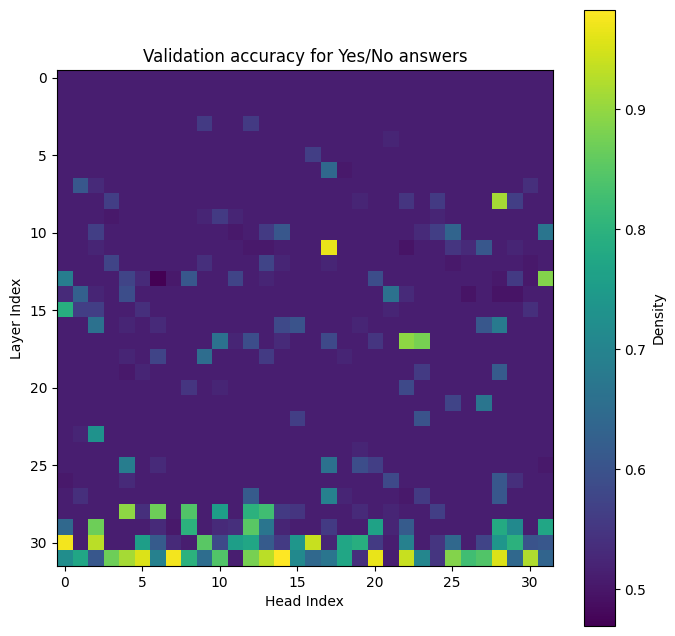

In [6]:
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
#data = np.random.rand(10,10) # Example data

data = all_head_accs_np.reshape(32,32) # np.random.rand(32, 32)  # Example data

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(data, cmap='viridis', interpolation='nearest')

heads = [(13, 0), (13, 11), (14, 0), (15, 5), (15, 7)]


# for head in heads: 
#     # Coordinates of the field you want to highlight
#     # Note: Matplotlib's coordinate system starts from the top left corner as (0, 0)
#     x = head[1]
#     y = head[0]
#     print(data[head[0], head[1]])
#     # Create a rectangle outline
#     # Arguments: (x, y) - lower left corner, width, height, edgecolor, and fill
#     rect = Rectangle((x-0.5, y-0.5), 1, 1, linewidth=2, edgecolor='r', facecolor='none')

#     # Add the rectangle to the Axes
#     ax.add_patch(rect)

# Add a colorbar associated with the Axes object's content
fig.colorbar(cax, ax=ax, label='Density')

# Set titles and labels
ax.set_title('Validation accuracy for Yes/No answers')
ax.set_xlabel('Head Index')
ax.set_ylabel('Layer Index')

plt.show()

In [8]:
def generate_majority_predictions(df): 
    predict = {}
    predict = []
    for req_id in df['req_id'].unique(): 

        req_df = df[df['req_id'] == req_id]
        maj_ele = req_df['predict'].value_counts().index[0]
        uncertainty = max(req_df['predict'].value_counts()) / len(req_df)
        #print(req_id)
        
        mean_score = req_df[(req_df['req_id']==req_id)& (req_df['predict']!= "undefined") & (req_df['score']!="undefined")].score.mean()
        
        #predict[req_id] = {"majority_predict" : maj_ele, "uncertainty" : uncertainty}
        predict.append({"req_id": req_id, "majority_predict" : maj_ele, "uncertainty" : uncertainty, "mean_score": mean_score})
    predict = pd.DataFrame(predict)
    return predict

In [9]:
df_openchat_inter = pd.read_json("./intervention_results/test_influence_of_different_100acc_heads/results_test_openchat_intervention_no_valid_35_1_fold_0_13_0.json")
predict_inter = generate_majority_predictions(df_openchat_inter)
print(df_openchat_inter.predict.value_counts())
print(predict_inter.majority_predict.value_counts())
predict_inter

predict
no           142
undefined     24
yes            8
Name: count, dtype: int64
majority_predict
no     29
yes     1
Name: count, dtype: int64


,req_id,majority_predict,uncertainty,mean_score
0,RQ-8-3,no,0.500000,0.900000
1,RQ-8-5,no,0.833333,0.816667
2,RQ-2-1,no,0.833333,0.828000
3,RQ-2-3,no,1.000000,0.785000
4,RQ-10,no,1.000000,0.768333
5,RQ-8-6,no,0.666667,0.782500
6,RQ-12-1,no,1.000000,0.808333
7,RQ-2-6,no,1.000000,0.610000
8,RQ-2-7,no,0.833333,0.636000
9,RQ-2-12,no,0.833333,0.920000


In [12]:
df_openchat_inter.predict.value_counts().to_dict()

{'no': 142, 'undefined': 24, 'yes': 8}

In [1]:
df[df.req_id.isin(filt)].predict.value_counts()

NameError: name 'df' is not defined

In [9]:
predict_baseline = generate_majority_predictions(df)
filt = df_openchat_inter.req_id.unique()
print(df[df.req_id.isin(filt)].predict.value_counts())
print(predict_baseline[predict_baseline.req_id.isin(filt)].majority_predict.value_counts())
predict_baseline

predict
yes    118
no      56
Name: count, dtype: int64
majority_predict
yes    19
no     11
Name: count, dtype: int64


,req_id,majority_predict,uncertainty,mean_score
0,RQ-8-1,no,1.000000,0.761667
1,RQ-8-2,yes,1.000000,0.816000
2,RQ-8-3,yes,0.833333,0.895000
3,RQ-8-4,no,1.000000,0.860000
4,RQ-8-5,yes,0.666667,0.773333
5,RQ-2-1,yes,1.000000,0.888333
6,RQ-2-2,yes,0.833333,0.898333
7,RQ-2-3,no,0.833333,0.845000
8,RQ-2-4,no,0.666667,0.721667
9,RQ-2-5,no,1.000000,0.805000


In [40]:
def get_precision_recall(df):

    df_openchat = df
    predict_openchat = generate_majority_predictions(df_openchat)

    df_gpt4 = pd.read_json("./results_gpt4_cot_moon_complete.json")
    predict_gpt4 = generate_majority_predictions(df_gpt4)

    # Merge the DataFrames on the 'req_id' column
    merged_df = pd.merge(predict_gpt4, predict_openchat, on='req_id', suffixes=('_gpt4', '_openchat'))

    # Compare the values in the 'majority_predict' column
    merged_df['is_same'] = merged_df['majority_predict_gpt4'] == merged_df['majority_predict_openchat']
    #print(merged_df.head(5))

    df1 = df_openchat
    df2 = merged_df
    key = "req_id"
    # Merging df1 with a column (value2) from df2 using 'key' as the common column
    df = df1.merge(df2[[key, 'majority_predict_openchat',"uncertainty_openchat",'is_same']], on=key, how='left')
    df = df.rename(columns={'is_same':'correct'})
    #print(df.head(5))
    #df = df[df['uncertainty_openchat_x'] > 0.5]


    precision = len(df[(df.final_answer == True) & (df.correct == True)]) / (len(df[(df.final_answer == True) & (df.correct == True)]) + len(df[(df.final_answer == True) & (df.correct == False)]))

    recall = len(df[(df.final_answer == True) & (df.correct == True)]) / (len(df[(df.final_answer == True) & (df.correct == True)]) + len(df[(df.final_answer == False) & (df.correct == False)]))

    return precision, recall

In [42]:
df_openchat = df
predict_openchat = generate_majority_predictions(df_openchat)

df_gpt4 = pd.read_json("./results_gpt4_cot_moon_complete.json")
predict_gpt4 = generate_majority_predictions(df_gpt4)

# Merge the DataFrames on the 'req_id' column
merged_df = pd.merge(predict_gpt4, predict_openchat, on='req_id', suffixes=('_gpt4', '_openchat'))

# Compare the values in the 'majority_predict' column
merged_df['is_same'] = merged_df['majority_predict_gpt4'] == merged_df['majority_predict_openchat']
#print(merged_df.head(5))

df1 = df_openchat
df2 = merged_df
key = "req_id"
# Merging df1 with a column (value2) from df2 using 'key' as the common column
df = df1.merge(df2[[key, 'majority_predict_openchat',"uncertainty_openchat",'is_same']], on=key, how='left')
df = df.rename(columns={'is_same':'correct'})

In [51]:
#df.correct


In [63]:
#precision, recall = get_precision_recall(df)

In [34]:
#df['uncertainty_openchat']

In [73]:
df = pd.read_json("requirements_data/dataframe_open_chat_cot_moon_06022024_attentions_gt.json")

precision = len(df[(df.final_answer == True) & (df.correct == True)]) / (len(df[(df.final_answer == True) & (df.correct == True)]) + len(df[(df.final_answer == True) & (df.correct == False)]))
recall = len(df[(df.final_answer == True) & (df.correct == True)]) / (len(df[(df.final_answer == True) & (df.correct == True)]) + len(df[(df.final_answer == False) & (df.correct == False)]))


In [75]:
precision

0.5507246376811594

In [74]:
recall

0.8837209302325582

In [68]:
#df_openchat_inter

In [53]:
precision, recall = get_precision_recall(df_openchat_inter)

In [54]:
precision

1.0

In [55]:
recall

0.1568627450980392

In [12]:
req_id = "RQ-2-1"
df_openchat = df
print("Requirement: ", df_openchat[df_openchat.req_id == req_id].requirement.values[0])
print("Intervened")
for out in df_openchat_inter[df_openchat_inter.req_id == req_id].output.values:
    print("____________")
    print(out)

print("No changes")
for out in df_openchat[df_openchat.req_id == req_id].output.values:
    print("____________")
    print(out)

Requirement:  The settlement shall provide food preparation facilities
Intervened
____________


1. The System describes a closed-loop system for sustaining life in a settlement.
2. The settlement is composed of multiple components such as Logical System, Food Loop, Water Loop, Air Loop, and others.
3. The Food Loop is responsible for producing food and recovering nutrients from solid waste.
4. The Prepare Food component is part of the Food Loop and is performed by the crew.

The requirement states that the settlement should provide food preparation facilities. However, based on the given System description, the food preparation process (Prepare Food) is performed by the crew, not by the settlement itself.

Therefore, the answer is No. The requirement is not satisfied.

Final Answer: No. <|end_of_turn|>
____________


1. The System describes various loops and processes related to food production, water management, air management, waste management, power, habitation, and other subsystem